In [ ]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

np.random.seed(500)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def NLP(path):
  #Leemos los datos a preprocesar
  Corpus = pd.read_csv(path,encoding='latin-1')
  #cambia el nombre de las columnas si estan intercambiadas 
  if Corpus.columns is not ['text','label']:
    Corpus.columns = ['text','label']

  # Paso - 1: Preprocesamiento de datos: esto ayudará a obtener mejores resultados a través de los algoritmos de clasificación.
  # Paso - 1a: Elimine las filas en blanco si las hay.
  Corpus['text'].dropna(inplace=True)

  # Paso - 1b: Cambia todo el texto a minúsculas. Esto es necesario ya que Python interpreta 'perro' y 'PERRO' de manera diferente
  Corpus['text'] = [entry.lower() for entry in Corpus['text']]

  # Paso - 1c: Tokenización: en este, cada entrada del corpus se dividirá en un conjunto de palabras 
  Corpus['text']= [word_tokenize(entry) for entry in Corpus['text']]

  # Paso - 1d: Elimine palabras vacías, no numéricas y ejecute palabras derivadas / lemmentadas.
  
  # WordNetLemmatizer requiere etiquetas Pos para comprender si la palabra es sustantivo, verbo o adjetivo, etc. 
  #De forma predeterminada, se establece en Noun
  tag_map = defaultdict(lambda : wn.NOUN)
  tag_map['J'] = wn.ADJ
  tag_map['V'] = wn.VERB
  tag_map['R'] = wn.ADV
  
  for index,entry in enumerate(Corpus['text']):
    # Declarar lista vacía para almacenar las palabras que siguen las reglas de este paso
    Final_words = []
    # Inicializando WordNetLemmatizer ()
    word_Lemmatized = WordNetLemmatizer()
    #La función pos_tag a continuación proporcionará la 'etiqueta', es decir, si la palabra es Sustantivo (N) o Verbo (V) o algo más.
    for word, tag in pos_tag(entry):
        # La siguiente condición es verificar las palabras vacías y considerar solo los alfabetos
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # El conjunto final de palabras procesadas para cada iteración se almacenará en 'text_final'
    Corpus.loc[index,'text_final'] = str(Final_words)

  return [Corpus['text_final'],Corpus['label']]  

In [ ]:
def TF_IDF(X,Y):
  # Paso - 2: Divida el modelo en un conjunto de datos de prueba y entrenamiento
  Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(X,Y,test_size=0.3)
  
  # Paso - 3: Etiqueta codificar la variable de destino :
  #Esto se hace para transformar los datos categóricos del tipo de cadena en el conjunto de datos en valores numéricos
  # 0:=positivo, 1:=negativo
  Encoder = LabelEncoder()
  Train_Y = Encoder.fit_transform(Train_Y)
  Test_Y = Encoder.fit_transform(Test_Y)
  
  # Paso - 4: Vectorizar las palabras usando TF-IDF Vectorizer 
  #Esto se hace para encontrar qué tan importante es una palabra en el documento del corpus
  Tfidf_vect = TfidfVectorizer(max_features=5000)
  Tfidf_vect.fit(X)
  
  Train_X_Tfidf = Tfidf_vect.transform(Train_X)
  Test_X_Tfidf = Tfidf_vect.transform(Test_X)

  return [Train_X_Tfidf,Test_X_Tfidf,Train_Y,Test_Y]

In [ ]:
def SVM(SVM_TRAIN_X,SVM_TEST_X,SVM_TRAIN_Y,SVM_TEST_Y):
  
  # Clasificador - Algoritmo - SVM
  # Ajustar el conjunto de datos de entrenamiento en el clasificador
  SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
  SVM.fit(SVM_TRAIN_X,SVM_TRAIN_Y)
  
  # predecir las etiquetas en el conjunto de datos de validación
  predictions_SVM = SVM.predict(SVM_TEST_X)
  
  # Utilice la función precision_score para obtener la precisión
  return predictions_SVM

In [ ]:
def AC_MC(SVM_TEST_Y,PRED):
  cm = metrics.confusion_matrix(SVM_TEST_Y, PRED)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  print("Confusion matrix:")
  all_sample_title = 'Accuracy Score: {0}%'.format(np.round(accuracy_score(PRED, SVM_TEST_Y)*100,2))
  plt.title(all_sample_title, size = 12)

In [ ]:
def pred_vs_real(path,prediction,N):
  Corpus = pd.read_csv(path,encoding='latin-1')
  Encoder = LabelEncoder()
  label = Encoder.fit_transform(Corpus.label)
  for i in range(N):
    print('El sentimiento predicho es: ',prediction[i],'el sentimiento real es: ',label[i] ,'la opinion real es: ',Corpus.text[i])

In [ ]:
X,Y=NLP(path="/content/drive/MyDrive/PRACTICA II/SEMANA 3/corpus.csv")

In [ ]:
SVM_TRAIN_X,SVM_TEST_X,SVM_TRAIN_Y,SVM_TEST_Y = TF_IDF(X=X,Y=Y)

In [ ]:
pred = SVM(SVM_TRAIN_X=SVM_TRAIN_X,SVM_TEST_X= SVM_TEST_X,SVM_TRAIN_Y= SVM_TRAIN_Y,SVM_TEST_Y= SVM_TEST_Y)

Confusion matrix:


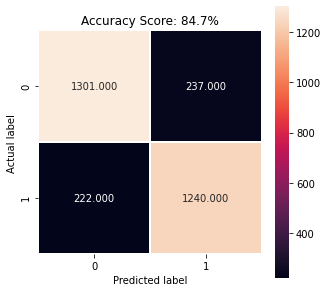

In [ ]:
AC_MC(SVM_TEST_Y=SVM_TEST_Y,PRED=pred)

In [ ]:
pred_vs_real(path="/content/drive/MyDrive/PRACTICA II/SEMANA 3/corpus.csv",prediction=pred,N=9)

El sentimiento predicho es:  0 el sentimiento real es:  1 la opinion real es:   Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate video game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^
El sentimiento predicho es:  0 el sentimiento real es:  1 la opinion real es:   The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are goin

**Otro DataFreame**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/movies_reviews.csv')
df.columns = ['text','label']
df.to_csv('reviews.csv')
df

,text,label
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0
...,...,...
49995,"OK, lets start with the best. the building. al...",0
49996,The British 'heritage film' industry is out of...,0
49997,I don't even know where to begin on this one. ...,0
49998,Richard Tyler is a little boy who is scared of...,0


In [ ]:
df.to_csv('reviews.csv')

In [ ]:
X,Y=NLP(path="/content/reviews.csv")

Confusion matrix:


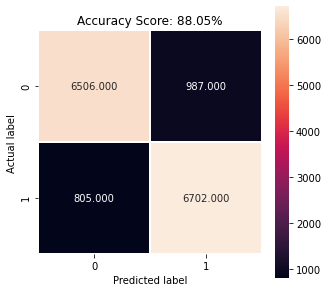

In [ ]:
SVM_TRAIN_X,SVM_TEST_X,SVM_TRAIN_Y,SVM_TEST_Y = TF_IDF(X=X,Y=Y)
pred = SVM(SVM_TRAIN_X=SVM_TRAIN_X,SVM_TEST_X= SVM_TEST_X,SVM_TRAIN_Y= SVM_TRAIN_Y,SVM_TEST_Y= SVM_TEST_Y)
AC_MC(SVM_TEST_Y=SVM_TEST_Y,PRED=pred)

In [ ]:
pred_vs_real(path="/content/reviews.csv",prediction=pred,N=9)

El sentimiento predicho es:  0 el sentimiento real es:  1 la opinion real es:  In 1974, the teenager Martha Moxley (Maggie Grace) moves to the high-class area of Belle Haven, Greenwich, Connecticut. On the Mischief Night, eve of Halloween, she was murdered in the backyard of her house and her murder remained unsolved. Twenty-two years later, the writer Mark Fuhrman (Christopher Meloni), who is a former LA detective that has fallen in disgrace for perjury in O.J. Simpson trial and moved to Idaho, decides to investigate the case with his partner Stephen Weeks (Andrew Mitchell) with the purpose of writing a book. The locals squirm and do not welcome them, but with the support of the retired detective Steve Carroll (Robert Forster) that was in charge of the investigation in the 70's, they discover the criminal and a net of power and money to cover the murder.<br /><br />"Murder in Greenwich" is a good TV movie, with the true story of a murder of a fifteen years old girl that was committed 

# **PRUEBA PAQUETE Y POO**

In [ ]:
Corpus = pd.read_csv("/content/drive/MyDrive/PRACTICA II/SEMANA 3/corpus.csv",encoding='latin-1')

In [ ]:
Corpus.head()

,text,label
0,Stuning even for the non-gamer: This sound tr...,__label__2
1,The best soundtrack ever to anything.: I'm re...,__label__2
2,Amazing!: This soundtrack is my favorite musi...,__label__2
3,Excellent Soundtrack: I truly like this sound...,__label__2
4,"Remember, Pull Your Jaw Off The Floor After H...",__label__2


In [ ]:
class Preprocesamiento:
  def __init__(self, path):
        self.path = path
        
  def NLP(path):
    Corpus = pd.read_csv(path,encoding='latin-1')
    
    if Corpus.columns is not ['text','label']:
      Corpus.columns = ['text','label']
      
    # Paso - 1: Preprocesamiento de datos: esto ayudará a obtener mejores resultados a través de los algoritmos de clasificación.
    # Paso - 1a: Elimine las filas en blanco si las hay.
    Corpus['text'].dropna(inplace=True)
    
    # Paso - 1b: Cambia todo el texto a minúsculas. Esto es necesario ya que Python interpreta 'perro' y 'PERRO' de manera diferente
    Corpus['text'] = [entry.lower() for entry in Corpus['text']]
    
    # Paso - 1c: Tokenización: en este, cada entrada del corpus se dividirá en un conjunto de palabras 
    Corpus['text']= [word_tokenize(entry) for entry in Corpus['text']]
    
    # Paso - 1d: Elimine palabras vacías, no numéricas y ejecute palabras derivadas / lemmentadas.
    
    # WordNetLemmatizer requiere etiquetas Pos para comprender si la palabra es sustantivo, verbo o adjetivo, etc.
    
    #De forma predeterminada, se establece en Noun
    tag_map = defaultdict(lambda : wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV
    
    for index,entry in enumerate(Corpus['text']):
      # Declarar lista vacía para almacenar las palabras que siguen las reglas de este paso
      Final_words = []
      # Inicializando WordNetLemmatizer ()
      word_Lemmatized = WordNetLemmatizer()
      #La función pos_tag a continuación proporcionará la 'etiqueta', es decir, si la palabra es Sustantivo (N) o Verbo (V) o algo más.
      for word, tag in pos_tag(entry):
        # La siguiente condición es verificar las palabras vacías y considerar solo los alfabetos
        if word not in stopwords.words('english') and word.isalpha():
          word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
          Final_words.append(word_Final)
      # El conjunto final de palabras procesadas para cada iteración se almacenará en 'text_final'
      Corpus.loc[index,'text_final'] = str(Final_words)
    
    # Paso - 2: Divida el modelo en un conjunto de datos de prueba y entrenamiento
    Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(Corpus['text_final'],Corpus['label'],test_size=0.3)
    
    # Paso - 3: Etiqueta codificar la variable de destino :
    #Esto se hace para transformar los datos categóricos del tipo de cadena en el conjunto de datos en valores numéricos
    # 0:=positivo, 1:=negativo
    Encoder = LabelEncoder()
    Train_Y = Encoder.fit_transform(Train_Y)
    Test_Y = Encoder.fit_transform(Test_Y)
    
    # Paso - 4: Vectorizar las palabras usando TF-IDF Vectorizer 
    #Esto se hace para encontrar qué tan importante es una palabra en el documento del corpus
    Tfidf_vect = TfidfVectorizer(max_features=5000)
    Tfidf_vect.fit(Corpus['text_final'])
    
    Train_X_Tfidf = Tfidf_vect.transform(Train_X)
    Test_X_Tfidf = Tfidf_vect.transform(Test_X)
    
    return [Train_X_Tfidf,Test_X_Tfidf,Train_Y,Test_Y]  

In [ ]:
class PREDICCION_METRICAS_VS:

  def __init__(self, SVM_TRAIN_X,SVM_TEST_X,SVM_TRAIN_Y,SVM_TEST_Y,PRED,prediction,N):
    self.SVM_TRAIN_X = SVM_TRAIN_X
    self.SVM_TEST_X  = SVM_TEST_X
    self.SVM_TRAIN_Y = SVM_TRAIN_Y
    self.SVM_TEST_Y  = SVM_TEST_Y
    self.PRED        = PRED
    self.prediction   = prediction
    self.N           = N

  def SVM(SVM_TRAIN_X,SVM_TEST_X,SVM_TRAIN_Y,SVM_TEST_Y):
    
    # Clasificador - Algoritmo - SVM
    # Ajustar el conjunto de datos de entrenamiento en el clasificador
    SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
    SVM.fit(SVM_TRAIN_X,SVM_TRAIN_Y)
    
    # predecir las etiquetas en el conjunto de datos de validación
    predictions_SVM = SVM.predict(SVM_TEST_X)
    
    # Utilice la función precision_score para obtener la precisión
    return predictions_SVM

  def AC_MC(SVM_TEST_Y,PRED):
    cm = metrics.confusion_matrix(SVM_TEST_Y, PRED)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    print("Confusion matrix:")
    all_sample_title = 'Accuracy Score: {0}%'.format(np.round(accuracy_score(PRED, SVM_TEST_Y)*100,2))
    plt.title(all_sample_title, size = 12)

  
  def pred_vs_real(path,prediction,N):
    Corpus = pd.read_csv(path,encoding='latin-1')
    Encoder = LabelEncoder()
    label = Encoder.fit_transform(Corpus.label)
    for i in range(N):
      print('El sentimiento predicho es: ',prediction[i],'el sentimiento real es: ',label[i] ,'la opinion real es: ',Corpus.text[i])




In [ ]:
 SVM_TRAIN_X,SVM_TEST_X,SVM_TRAIN_Y,SVM_TEST_Y = Preprocesamiento.NLP("/content/drive/MyDrive/PRACTICA II/SEMANA 3/corpus.csv")

Confusion matrix:


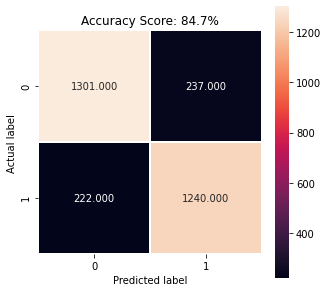

In [ ]:
pred = PREDICCION_METRICAS_VS.SVM(SVM_TRAIN_X=SVM_TRAIN_X,SVM_TEST_X= SVM_TEST_X,SVM_TRAIN_Y= SVM_TRAIN_Y,SVM_TEST_Y= SVM_TEST_Y)
PREDICCION_METRICAS_VS.AC_MC(SVM_TEST_Y=SVM_TEST_Y,PRED=pred)

In [ ]:
PREDICCION_METRICAS_VS.pred_vs_real("/content/drive/MyDrive/PRACTICA II/SEMANA 3/corpus.csv",pred,9)

El sentimiento predicho es:  0 el sentimiento real es:  1 la opinion real es:   Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate video game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^
El sentimiento predicho es:  0 el sentimiento real es:  1 la opinion real es:   The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are goin